<div style="text-align: center"><span style="font-size: 24px; font-weight: bold;">Data modeling</span></div>

## 1. Phát biểu vấn đề

- Mức độ phổ biến (Popularity) của một manga là một yếu tố quan trọng phản ánh mức độ thu hút và quan tâm của cộng đồng độc giả trên nền tảng MyAnimeList. Hiểu và dự đoán mức độ phổ biến không chỉ giúp nhà xuất bản hoặc tác giả xác định các yếu tố thành công mà còn hỗ trợ người dùng tìm kiếm những tác phẩm phù hợp với sở thích cá nhân.

- Tuy nhiên, sự phổ biến của manga phụ thuộc vào nhiều yếu tố, bao gồm thể loại (Genres), chủ đề (Themes), đối tượng độc giả (Demographics), số lượng độc giả đánh giá (Vote, Members), tình trạng phát hành (Status), và các đặc điểm chất lượng như điểm số trung bình (Score). Các yếu tố này có mối quan hệ phức tạp và không dễ dàng được phân tích chỉ bằng quan sát trực quan.

- Mục tiêu của bài toán là dự đoán mức độ phổ biến (Popularity) của manga dựa trên các đặc điểm liên quan, qua đó xác định các yếu tố quan trọng như thể loại (Genres), đối tượng độc giả (Demographics), hay số lượng đánh giá (Vote, Members). Điều này không chỉ giúp hiểu rõ hơn mối quan hệ giữa các đặc điểm và mức độ phổ biến mà còn hỗ trợ dự đoán sự thành công của các manga mới hoặc các tác phẩm tiềm năng, từ đó tối ưu hóa chiến lược xuất bản và quảng bá.

- Ngoài ra, việc triển khai và so sánh các thuật toán như Linear Regression, Decision Tree, và XGBoost sẽ giúp đánh giá hiệu suất của từng phương pháp trong việc dự đoán và xử lý dữ liệu phức tạp. Kết quả từ bài toán này không chỉ cung cấp cơ sở lý thuyết mà còn có thể ứng dụng vào các hệ thống gợi ý (recommendation systems), góp phần nâng cao trải nghiệm người dùng và giá trị thương mại của các tác phẩm manga.

## 2. Chuẩn bị dữ liệu

Trước khi tiến hành mô hình hóa, việc lựa chọn các đặc trưng (features) phù hợp là bước quan trọng để đảm bảo tính hiệu quả và độ chính xác của mô hình. 

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, cross_val_score

In [7]:
manga_df = pd.read_csv('../Preprocessing/Preprocessed Data/Raw Manga/raw_manga_proccessed_updated.csv')

In [8]:
pd.set_option('display.max_columns', None)
manga_df.head()

,Title,Score,Vote,Ranked,Popularity,Members,Favorite,Types,Volumes,Chapters,Status,Genres,Demographic,Serialization,Author,Released date,Completed date,Total Review,Recommended,Mixed Feelings,Not Recommended
0,Berserk,9.47,363720,1,1,725079,130489,Manga,3,16,Publishing,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Young Animal,"[""'Miura,Kentarou'"", ""'Studio Gaga'""]",1989-08-25,Updating,289,252,17,20
1,JoJo no Kimyou na Bouken Part 7: Steel Ball Ru...,9.31,172219,2,23,280428,46269,Manga,24,96,Finished,"[""'Action'"", ""'Adventure'"", ""'Mystery'"", ""'Sup...",Seinen,Ultra Jump,"[""'Araki,Hirohiko'""]",2004-01-19,2011-04-19,131,123,7,1
2,Vagabond,9.26,154583,3,13,406082,44258,Manga,37,327,On Hiatus,"[""'Action'"", ""'Adventure'"", ""'Award Winning'"",...",Seinen,Morning,"[""'Inoue,Takehiko'"", ""'Yoshikawa,Eiji'""]",1998-09-03,2015-05-21,104,93,9,2
3,One Piece,9.22,392811,4,4,642620,119974,Manga,3,16,Publishing,"[""'Action'"", ""'Adventure'"", ""'Fantasy'""]",Shounen,Shounen Jump (Weekly),"[""'Oda,Eiichiro'""]",1997-07-22,Updating,231,190,21,20
4,Monster,9.16,104327,5,29,258581,22008,Manga,18,162,Finished,"[""'Award Winning'"", ""'Drama'"", ""'Mystery'"", ""'...",Seinen,Big Comic Original,"[""'Urasawa,Naoki'""]",1994-12-05,2001-12-20,86,69,11,6


### **2.1 Lựa chọn các tính năng**

Để có chất lượng của việc dự đoán là tốt nhất thì sẽ chọn ra những đặc trưng phù hợp nhất và bỏ đi những đặc trưng không cần thiết 
- `Title`: Tên manga không phải là một đặc trưng định lượng hay định tính có ý nghĩa trong việc dự đoán mức độ phổ biến. Tên không chứa thông tin nào ảnh hưởng trực tiếp đến mức độ phổ biến, trừ khi được xử lý NLP, nhưng điều này không phù hợp với bài toán hiện tại.
- `Author`: Tác giả chỉ có ảnh hưởng trong một số trường hợp đặc biệt (ví dụ: tác giả nổi tiếng), nhưng việc chuẩn hóa dữ liệu này rất khó khăn và thường không đồng nhất. Ngoài ra, mức độ phổ biến của manga thường do nội dung quyết định hơn là danh tiếng của tác giả.
- `Released date` và `Completed date`: Ngày phát hành và ngày hoàn thành thường không ảnh hưởng trực tiếp đến mức độ phổ biến. Một số manga cũ vẫn có thể phổ biến (như những tác phẩm kinh điển), trong khi một số manga mới có thể nhanh chóng nổi tiếng nhờ chiến lược marketing.
- `Mixed Feelings` và `Not Recommended`: Số lượng đánh giá "Mixed Feelings" và "Not Recommended" có thể mang ý nghĩa tiêu cực, nhưng chúng thường đã được phản ánh tổng quát qua Total Review và Vote. Do đó, thêm các cột này có thể gây dư thừa thông tin.
- `Demographic`: Đối tượng độc giả (Demographics) như Shounen, Seinen,... đã được thể hiện gián tiếp thông qua Genres và Type. Do đó, biến này không cần thiết khi các đặc điểm trên đã được chọn.
- `Serialization`: Nền tảng xuất bản (Serialization) chỉ phản ánh nơi đăng tải và không tác động trực tiếp đến sự phổ biến của manga, đặc biệt nếu nội dung hoặc thể loại không phù hợp với sở thích.
- `Score`: Phản ánh chất lượng manga nhưng không trực tiếp quyết định mức độ phổ biến. Một số manga có điểm cao nhưng vẫn không được nhiều người biết đến do không phù hợp sở thích hoặc thiếu quảng bá. Dùng Score có thể gây nhiễu khi dự đoán, vì nó có thể đã chịu ảnh hưởng từ các yếu tố khác như Vote hoặc Members.
- `Ranked`: Có mối tương quan chặt chẽ với Score, do đó không cần thiết khi đã loại bỏ Score. Đây cũng là một chỉ số thứ cấp, không phải đặc điểm gốc ảnh hưởng đến mức độ phổ biến.

In [11]:
df = manga_df.drop(columns=['Title','Author','Released date', 'Completed date', 'Demographic', 'Serialization', 'Ranked', 'Genres'])

In [12]:
df.dtypes

Score              float64
Vote                 int64
Popularity           int64
Members              int64
Favorite             int64
Types               object
Volumes              int64
Chapters             int64
Status              object
Total Review         int64
Recommended          int64
Mixed Feelings       int64
Not Recommended      int64
dtype: object

Ta có các đặc trưng Types, Status và Genres là có kiểu dữ liệu là object nên cần phải chuyển hóa lại thành int64

In [14]:
# Xem xét các giá trị có trong các cột này để chuyển hóa
print(df['Types'].unique())
print(df['Status'].unique())

['Manga' 'Novel' 'Light Novel' 'Manhua' 'Manhwa' 'One-shot' 'Doujinshi']
['Publishing' 'Finished' 'On Hiatus' 'Discontinued']


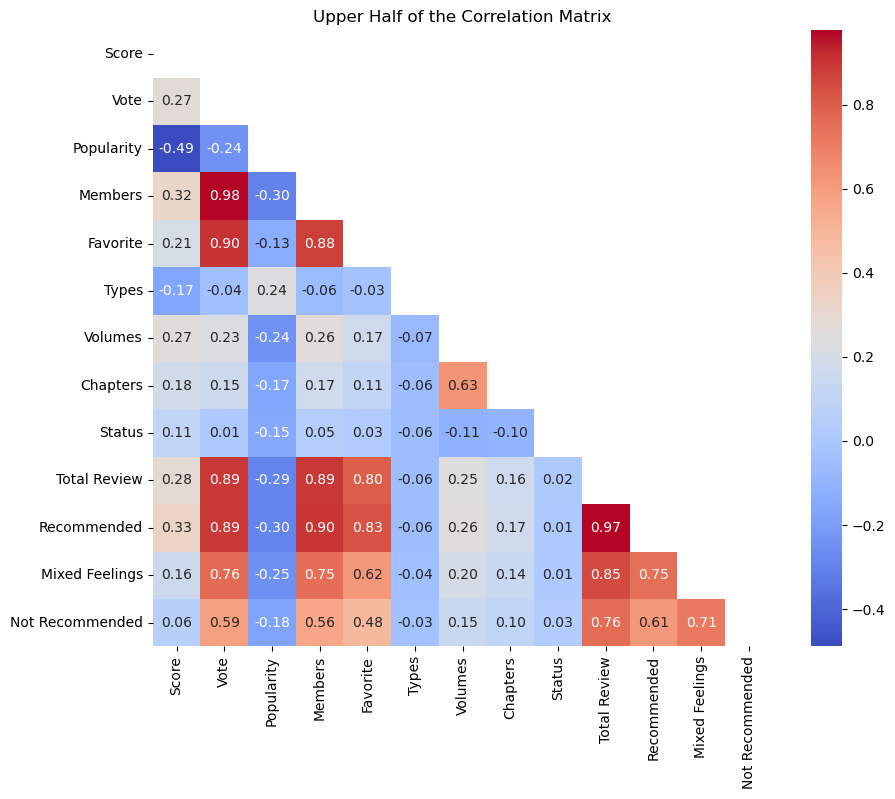

In [15]:
label_encoder = LabelEncoder()

# Chuẩn hóa cột 'Types' và Status sang int64
df['Types'] = label_encoder.fit_transform(df['Types'])
df['Status'] = label_encoder.fit_transform(df['Status'])

numeric_df = df.select_dtypes(include=['number'])

# Tính ma trận tương quan
correlation_matrix = numeric_df.corr()

# Lọc nửa trên của ma trận tương quan (chỉ hiển thị phần đối xứng trên)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Vẽ ma trận tương quan với nửa trên
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Upper Half of the Correlation Matrix')
plt.show()

Nhìn vào ma trận tương quan trên thì sẽ xóa những đặc trưng có mối tương quan thấp với mức độ phổ biến **< 0.2**

In [17]:
df.drop(columns=['Not Recommended', 'Status', 'Chapters', 'Favorite'], inplace=True)
df.head()

,Score,Vote,Popularity,Members,Types,Volumes,Total Review,Recommended,Mixed Feelings
0,9.47,363720,1,725079,2,3,289,252,17
1,9.31,172219,23,280428,2,24,131,123,7
2,9.26,154583,13,406082,2,37,104,93,9
3,9.22,392811,4,642620,2,3,231,190,21
4,9.16,104327,29,258581,2,18,86,69,11


### **2.2 Chia dữ liệu**

Trong bước này sẽ chia dữ liệu theo các bước sau:
- Xác định biến mục tiêu và các biến đặc trưng
- Chia dữ liệu ban đầu thành các tập huấn luyện, kiểm tra, xác thực với tỷ lệ **70:15:15**
- Chuẩn hóa dữ liệu bằng cách sử dụng MinMaxScaler

$$
x_{\text{scaled}} = \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}}
$$

In [20]:
features = df.drop(columns=['Popularity']).columns
target = 'Popularity'

# Chia ra các tập dữ liệu (70% train, 30% còn lại -> 20% test, 10% validation)
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=1/2, random_state=42)

# Chia dữ liệu cho các tập
X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]
X_val, y_val = val_data[features], val_data[target]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)

X_train shape: (13340, 8)
y_train shape: (13340,)
X_test shape: (2859, 8)
y_test shape: (2859,)
X_val shape: (2859, 8)
y_val shape: (2859,)


## 3. Tạo, huấn luyện và kiểm tra mô hình

### **Mô hình**

Để giải quyết vấn đề này thì sẽ dùng các mô hình học máy như:
- Linear Regression:
- Random Forest:
- XGBoost:

Để thuận tiện khi so sánh giữa các thuật toán hoặc báo cáo kết quả. Cần tạo ra biến để kiểm soát tính **ngẫu nhiên** trong quá trình huấn luyện hoặc xây dựng mô hình. Đảm bảo rằng kết quả của mô hình có thể được **tái lập** trong các lần chạy khác nhau

In [25]:
random_state = 42

Tạo ra 3 mô hình huấn luyện trong biến `models` được thêm các tham số vào sao cho có thể chạy được tốt nhất và ổn định với:
- `n_jobs`: để xác định số lượng luồng (threads) CPU sẽ được sử dụng để huấn luyện hoặc dự đoán. Việc gán `n_jobs=-1` có nghĩa là sẽ sử dụng **tất cả các luồng CPU** có sẵn trên máy tính để chạy. Do XGBoost và Random Forest đều thực hiện tính toán song song để tăng tốc huấn luyện và dự đoán nên dây là lựa chọn tối ưu để tận dụng tối đa tài nguyên phần cứng
- `random_state`: để các mô hình Random Forest và XGBoost sẽ chạy ra cùng một kết quả khi chạy lại với cùng dữ liệu

In [27]:
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(n_jobs=-1, random_state=random_state),
    'Random Forest': RandomForestRegressor(n_jobs=-1, random_state=random_state)
}

### **Thước đo để đánh giá mô hình**

Bài toán là dự đoán mức độ phổ biến (Popularity) của các thể loại manga là một bài toán hồi quy, cho nên sẽ dùng những thước đo phù hợp để đánh giá mô hình
- **Mean Squared Error (MSE)**
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

- **Mean Absolute Error (MAE)**

$$
\text{MAE} =  \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

- **R-squared ($R^2$) Score**
$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y}_i)^2}
$$
Trong đó:
- n: Số lượng mẫu dữ liệu
- $y_i$: Giá trị thực tế của mẫu thứ i
- $\hat{y}_i$: Giá trị dự đoán của mẫu thứ i
- $\bar{y}_i$:  Giá trị trung bình của biến phụ thuộc

Tạo ra hàm `evaluate_model` để đánh giá mô hình dựa trên các thước đo như trên

In [31]:
def evaluate_model(y_true, y_pred):
    """
    Tính toán các tiêu chí đánh giá MSE, MAE, R2 score.
    Args:
        y_true (array-like): Giá trị thực của mục tiêu.
        y_pred (array-like): Giá trị dự đoán từ mô hình.
    Returns:
        dict: Từ điển chứa MSE, MAE, và R2 score.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "MAE": mae, "R2": r2}

### **Huấn luyện mô hình trên tập huấn luyện**

#### 1. Tạo ra hàm `train_and_evaluate_model` để huấn luyện và đánh giá kết quả

In [34]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Huấn luyện mô hình và trả về mô hình đã huấn luyện cùng với kết quả đánh giá.
    Args:
        model: Mô hình cần huấn luyện.
        X_train, y_train: Dữ liệu huấn luyện.
        X_val, y_val: Dữ liệu validation.
        X_test, y_test: Dữ liệu kiểm tra.
    Returns:
        tuple: (Mô hình đã huấn luyện, kết quả đánh giá).
    """
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Dự đoán trên validation và test
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    test_preds = model.predict(X_test)
    
    # Đánh giá hiệu suất
    train_metrics = evaluate_model(y_train, train_preds) 
    val_metrics = evaluate_model(y_val, val_preds)
    test_metrics = evaluate_model(y_test, test_preds)
    
    # Trả về mô hình đã huấn luyện và kết quả đánh giá
    return model, {
        "Train": train_metrics,
        "Validation": val_metrics,
        "Test": test_metrics
    }

#### 2. Huấn luyện cho từng mô hình

In [36]:
trained_models = {}  # Lưu các mô hình đã huấn luyện
results = {}  # Lưu kết quả đánh giá

for model_name, model in models.items():
    print(f"Training and evaluating {model_name}...")
    trained_model, evaluation = train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
    trained_models[model_name] = trained_model
    results[model_name] = evaluation

Training and evaluating Linear Regression...
Training and evaluating XGBoost...
Training and evaluating Random Forest...


#### 3. Kiểm tra kết quả đánh giá

In [38]:
data = {}
data['Linear Regression'] = {}
data['Random Forest'] = {}
data['XGBoost'] = {}

for col in data.keys():
    data[col]['Train'] = {}
    data[col]['Validation'] = {}
    data[col]['Test'] = {}

data_set = ['Train','Validation','Test']

for col in data.keys():
    for dataset_name in data_set:
        data[col][dataset_name] = str(results[col][dataset_name])

# Tạo DataFrame từ danh sách
dff = pd.DataFrame(data)

pd.set_option('display.max_colwidth', None)  # Hiển thị đầy đủ nội dung trong mỗi ô

dff

,Linear Regression,Random Forest,XGBoost
Train,"{'MSE': 46327978.25567237, 'MAE': 5518.226688418061, 'R2': 0.3281144173933379}","{'MSE': 283.2095902998505, 'MAE': 1.7502113943028605, 'R2': 0.9999958926668561}","{'MSE': 1967.146232620811, 'MAE': 27.72646878219616, 'R2': 0.9999714708639932}"
Validation,"{'MSE': 47974435.83831912, 'MAE': 5686.179172706501, 'R2': 0.32429375804757987}","{'MSE': 988.2612880377803, 'MAE': 4.86774046869535, 'R2': 0.9999860806217032}","{'MSE': 72815.96975556659, 'MAE': 50.2100842897189, 'R2': 0.9989744078399697}"
Test,"{'MSE': 45284826.26624126, 'MAE': 5518.507989647926, 'R2': 0.33579531634843596}","{'MSE': 44880.227857572565, 'MAE': 8.100510668065754, 'R2': 0.999341729669645}","{'MSE': 197423.52328459662, 'MAE': 48.47672104610351, 'R2': 0.9971043362724265}"


#### 4. Trực quan hóa kết quả

Tạo ra hàm `plot_metrics` để trực quan hóa các tiêu chí thước cho cho các tập **validation** và **test**

In [41]:
def plot_metrics(evaluation):
    """
    Hàm vẽ đồ thị cho các chỉ số hiệu suất của mô hình trên các tập train, validation, và test.
    Args:
        metrics (dict): Từ điển chứa các chỉ số hiệu suất, gồm 'Train', 'Validation', và 'Test' cho mỗi chỉ số.
        model_name (str): Tên mô hình, dùng để đặt tiêu đề đồ thị.
    """
    categories = evaluation.keys()

    train_r2 = [evaluation[category]['Train']['R2'] for category in categories]
    test_r2 = [evaluation[category]['Test']['R2'] for category in categories]
    train_mse = [evaluation[category]['Train']['MSE'] for category in categories]
    test_mse = [evaluation[category]['Test']['MSE'] for category in categories]
    train_mae = [evaluation[category]['Train']['MAE'] for category in categories]
    test_mae = [evaluation[category]['Test']['MAE'] for category in categories]
    
    indices = np.arange(len(categories))
    # sns.set_style("darkgrid")
    sns.set(rc={"axes.facecolor":"#F2EAC5","figure.facecolor":"#F2EAC5"})
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    bars1_train = ax[0].bar(indices - 0.2, train_r2, width=0.4, label='Train', color='#8de5a1', linewidth=2, edgecolor='k')
    bars1_test = ax[0].bar(indices + 0.2, test_r2, width=0.4, label='Test', color='#ff9f9b', linewidth=2, edgecolor='k')
    ax[0].set_ylabel('R2 Score', fontsize=13, weight='bold')
    ax[0].set_xticks(indices)
    ax[0].set_xticklabels(categories)
    ax[0].set_title('Train and Test R2 Scores\n', fontsize=17, weight ='bold')
    ax[0].legend()
    ax[0].bar_label(bars1_train, fmt='%.2f', fontsize=12, color='black')
    ax[0].bar_label(bars1_test, fmt='%.2f', fontsize=12, color='black')
    
    # Bar chart for MSE
    bars2_train = ax[1].bar(indices - 0.2, train_mse, width=0.4, label='Train', color='#faa96e', linewidth=2, edgecolor='k')
    bars2_test = ax[1].bar(indices + 0.2, test_mse, width=0.4, label='Test', color='#d0bbff',  linewidth=2, edgecolor='k')
    ax[1].set_xticks(indices)
    ax[1].set_ylabel('MSE', fontsize=13, weight='bold')
    ax[1].set_xticklabels(categories)
    ax[1].set_title('Train and Test MSE\n', fontsize=17, weight ='bold')
    ax[1].legend()

    # Chuyển trục y sang thang log
    ax[1].set_yscale('log')
    
    ax[1].bar_label(bars2_train, fmt='%.2f', fontsize=12, color='black')
    ax[1].bar_label(bars2_test, fmt='%.2f', fontsize=12, color='black')

    # Bart chart for MAE
    bars3_train = ax[2].bar(indices - 0.2, train_mae, width=0.4, label='Train', color='#faa96e', linewidth=2, edgecolor='k')
    bars3_test = ax[2].bar(indices + 0.2, test_mae, width=0.4, label='Test', color='#d0bbff', linewidth=2, edgecolor='k')
    ax[2].set_ylabel('MAE', fontsize=13, weight='bold')
    ax[2].set_xticks(indices)
    ax[2].set_xticklabels(categories)
    ax[2].set_title('Train and Test MAE\n', fontsize=17, weight ='bold')
    ax[2].legend()

    # Chuyển trục y sang thang log
    ax[2].set_yscale('log')
    
    ax[2].bar_label(bars3_train, fmt='%.2f', fontsize=12, color='black')
    ax[2].bar_label(bars3_test, fmt='%.2f', fontsize=12, color='black')
    
    plt.show()

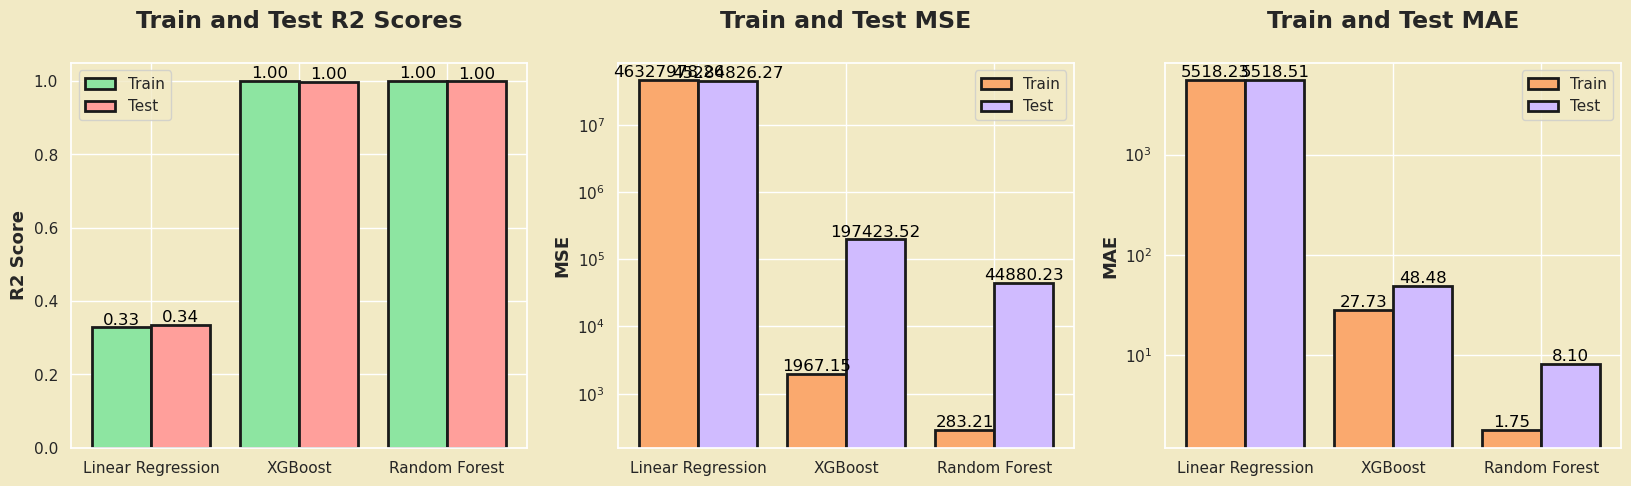

In [42]:
plot_metrics(results)

### **Tinh chỉnh mô hình trên tập xác thực**

Để có thể tìm ra các tham số tốt nhất cho các mô hình thì cần phải định nghĩa các tham số cho từng mô hình như sau:

In [46]:
# Định nghĩa các grid tham số cho từng mô hình
param_grids = {
    'Linear Regression': {
        # Không có nhiều tham số để tinh chỉnh cho Linear Regression
        'fit_intercept': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
    }
}

Sau đó cần thiết kế hàm `tune_model` để tìm các tham số tốt nhất

In [48]:
def tune_model(model, param_grid, X_train, y_train, X_val, y_val):
    # Thiết lập GridSearchCV
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Dự đoán với các tham số tốt nhất
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    # Đánh giá mô hình
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    # In kết quả
    print(f"\n--- {type(model).__name__} ---")
    print("Các tham số tốt nhất:", grid_search.best_params_)
    print("MSE:", mse)
    print("R2 Score:", r2)
    
    return {
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

Thực hiện việc tinh chỉnh cho từng mô hình:

In [50]:
# Từ điển để lưu kết quả
tuning_results = {}

# Thực hiện fine-tune cho từng mô hình
for model_name, model in models.items():
    tuning_results[model_name] = tune_model(
        model, 
        param_grids[model_name], 
        X_train, y_train, 
        X_val, y_val
    )

# Lưu kết quả vào file CSV
results_df = pd.DataFrame.from_dict(
    {model: result for model, result in tuning_results.items()}, 
    orient='index'
)
results_df.to_csv('model_tuning_results.csv')

# # In ra mô hình tốt nhất
# best_model_name = min(tuning_results, key=lambda x: tuning_results[x]['MSE'])
# print("\nMô hình tốt nhất:", best_model_name)
# print("Các tham số:", tuning_results[best_model_name]['best_params'])


--- LinearRegression ---
Các tham số tốt nhất: {'fit_intercept': True}
MSE: 47974435.83831912
R2 Score: 0.32429375804757987

--- XGBRegressor ---
Các tham số tốt nhất: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
MSE: 73343.62204864762
R2 Score: 0.9989669760079578

--- RandomForestRegressor ---
Các tham số tốt nhất: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
MSE: 988.2612880377803
R2 Score: 0.9999860806217032


Trực quan hóa kết quả khi tìm được các mô hình tốt nhất

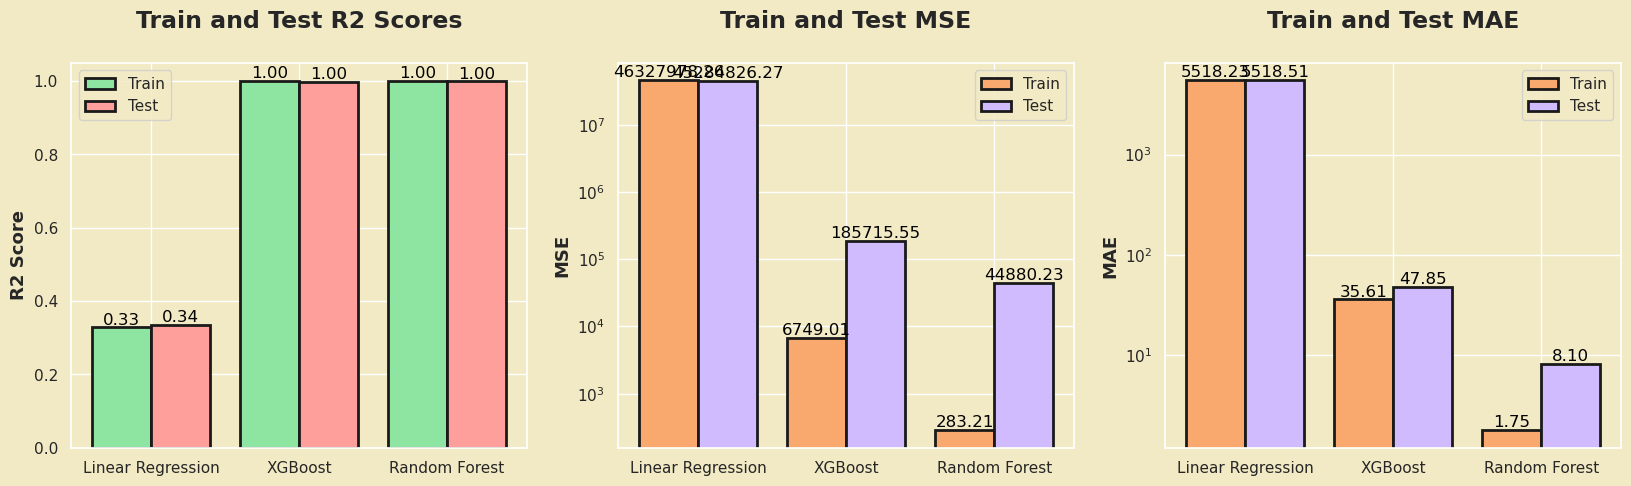

In [52]:
for model_name, model in tuning_results.items():
    trained_model, evaluation = train_and_evaluate_model(model['best_model'], X_train, y_train, X_val, y_val, X_test, y_test)
    trained_models[model_name] = trained_model
    results[model_name] = evaluation
plot_metrics(results)